In [1]:
palette = {
    'before-saline': 'orange',
    'after-saline': 'green',
    'before-drug': '#1F77B4',
    'after-drug': '#DA7F8C',
}

# curations = {
#     'D12_6': [9,10,11,14],
#     'D13_4': [7,8,10,11,13],
#     'D13_8': [14,23],
#     'D14_6': [1,8,15,25,37],
# }

threshold = 4.5
curations = {
    'saline': {
        'D12_6': [24,25,27,28,33],
        'D13_4': [14,28],
        'D13_8': [28,31],
        'D14_6': [1,27],#,56],
    },
    'drug': {
        'D12_6': [20,24,25,26,27,28,35],
        'D13_4': [14,20,24,28,29],
        'D13_8': [28,32,46],
        'D14_6': [1,17,64],
    }
}

rate_diffs = { 'saline': [], 'drug': [] }

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import scanpy
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se
from statannotations.Annotator import Annotator

figure_output_folder = 'data/processed/figures-2nd'
os.makedirs(figure_output_folder, exist_ok=True)    

ms_before = 2 
n_frames_per_ms = 30
spike_index = ms_before * n_frames_per_ms
n_s_per_min = 60
n_file = 8
n_file_per_condition = 4

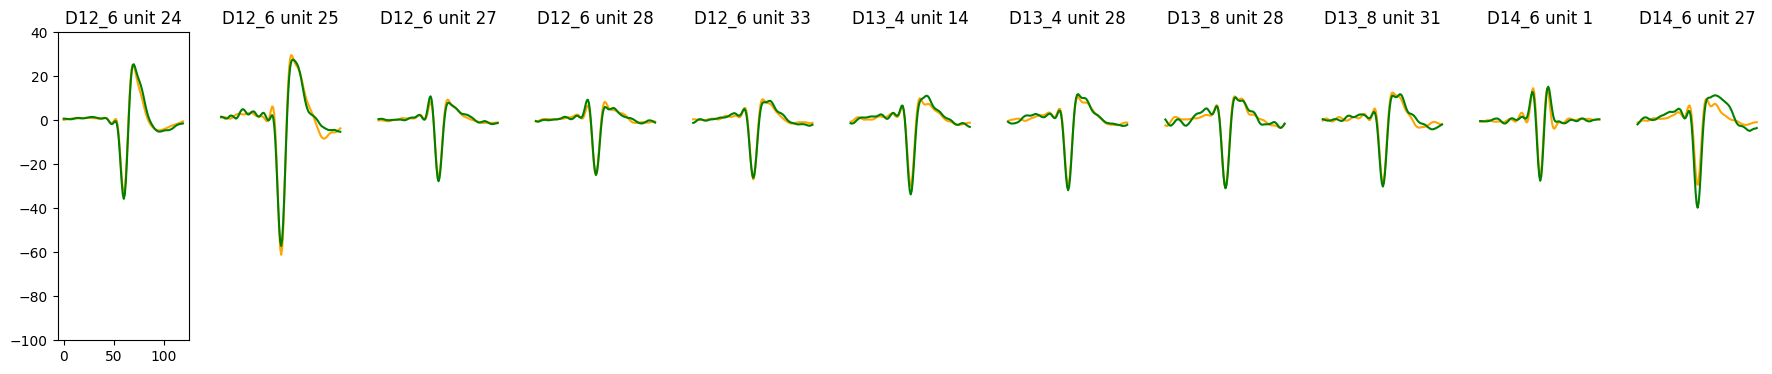

In [3]:
sortdate = '240506'
substance = 'saline'
unit_index = 1
n_unit = sum([len(units) for units in curations[substance].values()])


channel_indices = np.array([
    [ 0,  1,  2,  3,  7,  6,  5,  4],
    [ 8,  9, 10, 11, 15, 14, 13, 12],
    [16, 17, 18, 19, 23, 22, 21, 20],
    [24, 25, 26, 27, 31, 30, 29, 28],
    [32, 33, 34, 35, 39, 38, 37, 36],
    [40, 41, 42, 43, 47, 46, 45, 44],
    [48, 49, 50, 51, 55, 54, 53, 52],
    [56, 57, 58, 59, 63, 62, 61, 60],
    [64, 65, 66, 67, 71, 70, 69, 68],
    [72, 73, 74, 75, 79, 78, 77, 76],
])
def get_shank(channel_index):
    for shank, shank_index in enumerate(channel_indices):
        if channel_index in shank_index:
            return shank

waveforms_adatas = []
plt.figure(figsize=(n_unit*2, 4))
for subject, subject_units in curations[substance].items():
    recordings = [sc.load_extractor(f'data/processed/{subject}/{sortdate}/recordings/file{file_index}') for file_index in range(n_file)]
    recording = sc.concatenate_recordings(recordings)
    
    sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{sortdate}/sortings-{threshold}/sorter_output/firings.npz')
    # spikeinterface https://github.com/SpikeInterface/spikeinterface/pull/1378
    sorting = scu.remove_excess_spikes(sorting, recording)
    sortings = sc.split_sorting(sorting, recordings)
    sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in 
    range(len(recordings))]

    waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/{sortdate}/waveforms-{threshold}/file{file_index}', with_recording=True, sorting=sortings[file_index]) for file_index in range(n_file)]

    for unit_id in subject_units:
        all_channel_waveforms = [waveform_extractor.get_waveforms(unit_id) for waveform_extractor in waveform_extractors]

        extremum_channels = [sc.get_template_extremum_channel(waveform_extractor, peak_sign='neg')[unit_id] for waveform_extractor in waveform_extractors]
        extremum_shanks = [get_shank(extremum_channel) for extremum_channel in extremum_channels]

        waveforms = [all_channel_waveform[:, :, extremum_channel] for extremum_channel, all_channel_waveform in zip(extremum_channels, all_channel_waveforms)]
        ax = plt.subplot(1, n_unit, unit_index)
        template_before = np.vstack(waveforms[:n_file_per_condition]).mean(0)
        template_after = np.vstack(waveforms[n_file_per_condition:]).mean(0)
        ax.plot(template_before, color=palette[f'before-{substance}'])
        ax.plot(template_after, color=palette[f'after-{substance}'])
        ax.set_title(f'{subject} unit {unit_id}')
        ax.set_ylim(-100, 40)
        if unit_index != 1: ax.set_axis_off()
        unit_index += 1

        shank_waveforms = [all_channel_waveform[:, :, channel_indices[extremum_shank]] for extremum_shank, all_channel_waveform in zip(extremum_shanks, all_channel_waveforms)]
        shank_waveforms_before = np.vstack(shank_waveforms[:n_file_per_condition])
        shank_waveforms_after = np.vstack(shank_waveforms[n_file_per_condition:])
        shank_waveforms_before = shank_waveforms_before.reshape(shank_waveforms_before.shape[0], shank_waveforms_before.shape[1] * shank_waveforms_before.shape[2])
        shank_waveforms_after = shank_waveforms_after.reshape(shank_waveforms_after.shape[0], shank_waveforms_after.shape[1] * shank_waveforms_after.shape[2])
        
        adata_before = ad.AnnData(X=shank_waveforms_before, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': f'before-{substance}',
            'firing_rate': len(shank_waveforms_before) / n_s_per_min / n_file_per_condition,
            'trough': template_before[spike_index],
            'peak': template_before[spike_index:].max(),
        })
        
        adata_after = ad.AnnData(X=shank_waveforms_after, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': f'after-{substance}',
            'firing_rate': len(shank_waveforms_after) / n_s_per_min / n_file_per_condition,
            'trough': template_after[spike_index],
            'peak': template_after[spike_index:].max(),
        })

        waveforms_adatas.append(adata_before)
        waveforms_adatas.append(adata_after)
        
waveforms_adata = ad.concat(waveforms_adatas, index_unique='#')
plt.savefig(f'{figure_output_folder}/saline_templates.pdf')
plt.show()
plt.clf()
plt.close('all')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


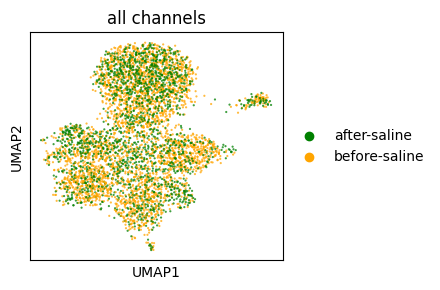

In [4]:
scanpy.pp.neighbors(waveforms_adata)
scanpy.tl.umap(waveforms_adata)

plt.figure(figsize=(4.5, 3))
ax = plt.subplot(1, 1, 1)
scanpy.pl.umap(waveforms_adata, color='condition', ax=ax, title='all channels', show=False, alpha=0.75, s=10, palette=palette)
plt.tight_layout()
plt.savefig(f'{figure_output_folder}/saline_umap.png', transparent=True)
plt.show()
plt.close()

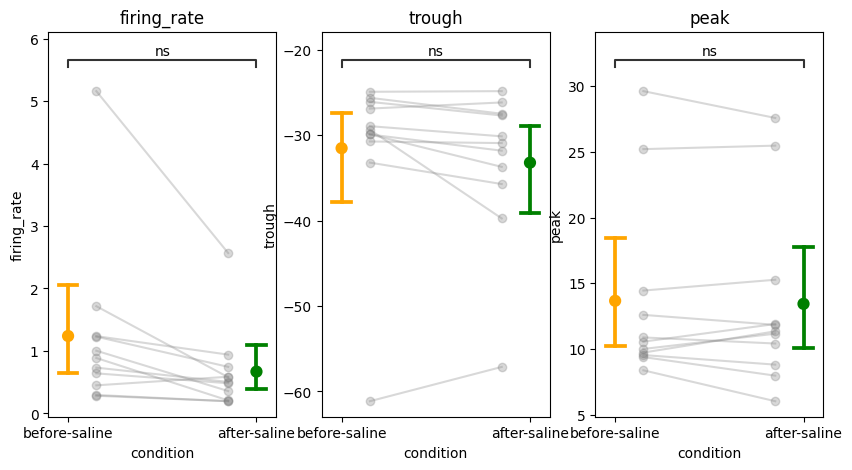

In [5]:
stats = waveforms_adata.obs.drop_duplicates()

def draw_feature(feature, ax):
    def closure(grouped):
        rate_before = grouped[grouped['condition'] == f'before-{substance}'][feature].item() if (grouped['condition'] == f'before-{substance}').sum() > 0 else 0
        rate_after = grouped[grouped['condition'] == f'after-{substance}'][feature].item() if (grouped['condition'] == f'after-{substance}').sum() > 0 else 0
        ax.plot([0.15, 0.85], [rate_before, rate_after], marker='o', color='gray', alpha=0.3)
    return closure

features = ['firing_rate', 'trough', 'peak']
plt.figure(figsize=(10, 5))
for feature_index, feature in (enumerate(features)):
    ax = plt.subplot(1, len(features), feature_index+1, zorder=1)
    stats.groupby(['subject', 'unit_id']).apply(draw_feature(feature, ax))
    ax.set_title(feature)
    sns.pointplot(data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'], ax=ax, capsize=0.1, palette=palette, zorder=10)
    annotator = Annotator(ax, [(f'before-{substance}', f'after-{substance}')], verbose=False, data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'])
    annotator.configure(test="t-test_welch").apply_and_annotate()
    
plt.savefig(f'{figure_output_folder}/saline_lines.pdf')
plt.show()
plt.close()

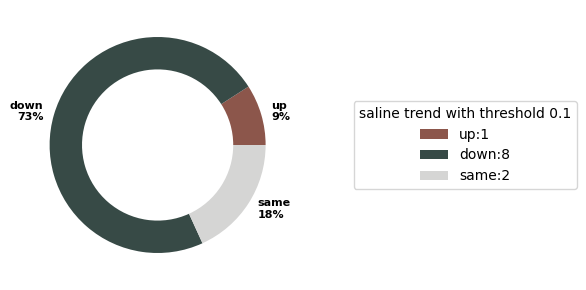

In [7]:
stats = waveforms_adata.obs.drop_duplicates()
unit_counts = {
    'up': 0,
    'down': 0,
    'same': 0,
}
no_change_threshold = 0.1
def count_unit(grouped):
    rate_after = grouped[grouped['condition'] == f'after-{substance}']['firing_rate'].item() if (grouped['condition'] == f'after-{substance}').sum() > 0 else 0
    rate_before = grouped[grouped['condition'] == f'before-{substance}']['firing_rate'].item() if (grouped['condition'] == f'before-{substance}').sum() > 0 else 0
    rate_diffs[substance].append(rate_after - rate_before)
    difference = abs(rate_after - rate_before)
    if difference <= no_change_threshold:
        unit_counts['same'] += 1
    elif rate_after > rate_before:
        unit_counts['up'] += 1
    else:
        unit_counts['down'] += 1
stats.groupby(['subject', 'unit_id']).apply(count_unit)

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

counts = list(unit_counts.values())
trend_counts = [f'{k}:{v}' for k,v in unit_counts.items()]
trend_percents = [f'{k}\n{v/sum(unit_counts.values())*100:0.0f}%' for k,v in unit_counts.items()]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, autotexts = ax.pie(counts, labels=trend_percents,
                                wedgeprops=dict(width=0.3), colors=['#8C564B', '#374A46', '#d5d5d4'])

ax.legend(wedges, trend_counts,
        title=f'{substance} trend with threshold {no_change_threshold}',
        loc="center left",
        bbox_to_anchor=(1.2, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(f'{figure_output_folder}/saline_donut.pdf', bbox_inches='tight')
plt.setp(autotexts, size=8, weight="bold")
plt.show()

/tmp/ipykernel_11728/2759895101.py:47: RuntimeWarning: Mean of empty slice.
  template_before = np.vstack(waveforms[:n_file_per_condition]).mean(0)
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


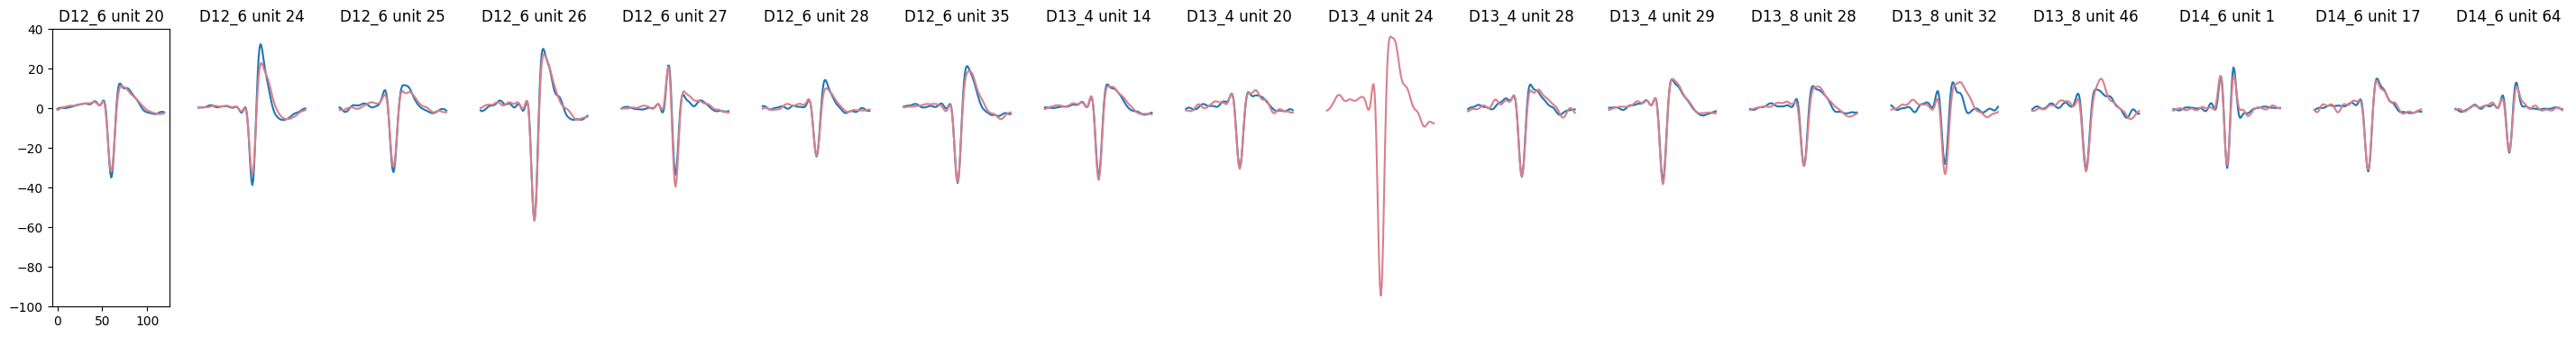

In [8]:
sortdate = '240507'
substance = 'drug'
unit_index = 1
n_unit = sum([len(units) for units in curations[substance].values()])


channel_indices = np.array([
    [ 0,  1,  2,  3,  7,  6,  5,  4],
    [ 8,  9, 10, 11, 15, 14, 13, 12],
    [16, 17, 18, 19, 23, 22, 21, 20],
    [24, 25, 26, 27, 31, 30, 29, 28],
    [32, 33, 34, 35, 39, 38, 37, 36],
    [40, 41, 42, 43, 47, 46, 45, 44],
    [48, 49, 50, 51, 55, 54, 53, 52],
    [56, 57, 58, 59, 63, 62, 61, 60],
    [64, 65, 66, 67, 71, 70, 69, 68],
    [72, 73, 74, 75, 79, 78, 77, 76],
])
def get_shank(channel_index):
    for shank, shank_index in enumerate(channel_indices):
        if channel_index in shank_index:
            return shank

waveforms_adatas = []
plt.figure(figsize=(n_unit*2, 4))
for subject, subject_units in curations[substance].items():
    recordings = [sc.load_extractor(f'data/processed/{subject}/{sortdate}/recordings/file{file_index}') for file_index in range(n_file)]
    recording = sc.concatenate_recordings(recordings)
    
    sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{sortdate}/sortings-{threshold}/sorter_output/firings.npz')
    # spikeinterface https://github.com/SpikeInterface/spikeinterface/pull/1378
    sorting = scu.remove_excess_spikes(sorting, recording)
    sortings = sc.split_sorting(sorting, recordings)
    sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in 
    range(len(recordings))]

    waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/{sortdate}/waveforms-{threshold}/file{file_index}', with_recording=True, sorting=sortings[file_index]) for file_index in range(n_file)]

    for unit_id in subject_units:
        all_channel_waveforms = [waveform_extractor.get_waveforms(unit_id) for waveform_extractor in waveform_extractors]

        extremum_channels = [sc.get_template_extremum_channel(waveform_extractor, peak_sign='neg')[unit_id] for waveform_extractor in waveform_extractors]
        extremum_shanks = [get_shank(extremum_channel) for extremum_channel in extremum_channels]

        waveforms = [all_channel_waveform[:, :, extremum_channel] for extremum_channel, all_channel_waveform in zip(extremum_channels, all_channel_waveforms)]
        ax = plt.subplot(1, n_unit, unit_index)
        template_before = np.vstack(waveforms[:n_file_per_condition]).mean(0)
        template_after = np.vstack(waveforms[n_file_per_condition:]).mean(0)
        ax.plot(template_before, color=palette[f'before-{substance}'])
        ax.plot(template_after, color=palette[f'after-{substance}'])
        ax.set_title(f'{subject} unit {unit_id}')
        ax.set_ylim(-100, 40)
        if unit_index != 1: ax.set_axis_off()
        unit_index += 1

        shank_waveforms = [all_channel_waveform[:, :, channel_indices[extremum_shank]] for extremum_shank, all_channel_waveform in zip(extremum_shanks, all_channel_waveforms)]
        shank_waveforms_before = np.vstack(shank_waveforms[:n_file_per_condition])
        shank_waveforms_after = np.vstack(shank_waveforms[n_file_per_condition:])
        shank_waveforms_before = shank_waveforms_before.reshape(shank_waveforms_before.shape[0], shank_waveforms_before.shape[1] * shank_waveforms_before.shape[2])
        shank_waveforms_after = shank_waveforms_after.reshape(shank_waveforms_after.shape[0], shank_waveforms_after.shape[1] * shank_waveforms_after.shape[2])
        
        adata_before = ad.AnnData(X=shank_waveforms_before, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': f'before-{substance}',
            'firing_rate': len(shank_waveforms_before) / n_s_per_min / n_file_per_condition,
            'trough': template_before[spike_index],
            'peak': template_before[spike_index:].max(),
        })
        
        adata_after = ad.AnnData(X=shank_waveforms_after, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': f'after-{substance}',
            'firing_rate': len(shank_waveforms_after) / n_s_per_min / n_file_per_condition,
            'trough': template_after[spike_index],
            'peak': template_after[spike_index:].max(),
        })

        waveforms_adatas.append(adata_before)
        waveforms_adatas.append(adata_after)
        
waveforms_adata = ad.concat(waveforms_adatas, index_unique='#')
plt.savefig(f'{figure_output_folder}/drug_templates.pdf')
plt.show()
plt.clf()
plt.close('all')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


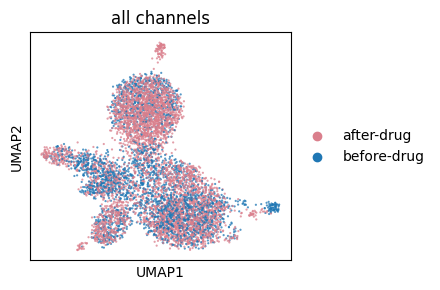

In [9]:
scanpy.pp.neighbors(waveforms_adata)
scanpy.tl.umap(waveforms_adata)

plt.figure(figsize=(4.5, 3))
ax = plt.subplot(1, 1, 1)
scanpy.pl.umap(waveforms_adata, color='condition', ax=ax, title='all channels', show=False, alpha=0.75, s=10, palette=palette)
plt.tight_layout()
plt.savefig(f'{figure_output_folder}/drug_umap.png', transparent=True)
plt.show()
plt.close()

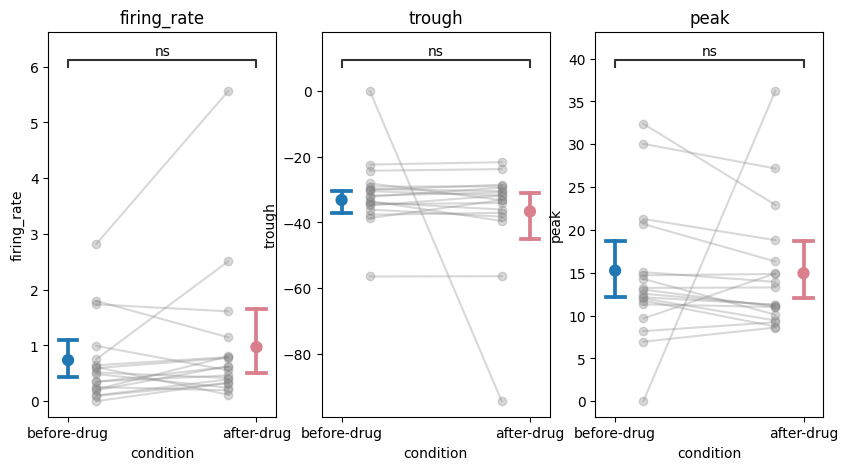

In [10]:
stats = waveforms_adata.obs.drop_duplicates()

def draw_feature(feature, ax):
    def closure(grouped):
        rate_before = grouped[grouped['condition'] == f'before-{substance}'][feature].item() if (grouped['condition'] == f'before-{substance}').sum() > 0 else 0
        rate_after = grouped[grouped['condition'] == f'after-{substance}'][feature].item() if (grouped['condition'] == f'after-{substance}').sum() > 0 else 0
        ax.plot([0.15, 0.85], [rate_before, rate_after], marker='o', color='gray', alpha=0.3)
    return closure

features = ['firing_rate', 'trough', 'peak']
plt.figure(figsize=(10, 5))
for feature_index, feature in (enumerate(features)):
    ax = plt.subplot(1, len(features), feature_index+1, zorder=1)
    stats.groupby(['subject', 'unit_id']).apply(draw_feature(feature, ax))
    ax.set_title(feature)
    sns.pointplot(data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'], ax=ax, capsize=0.1, palette=palette, zorder=10)
    annotator = Annotator(ax, [(f'before-{substance}', f'after-{substance}')], verbose=False, data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'])
    annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_output_folder}/drug_lines.pdf')
plt.show()
plt.close()

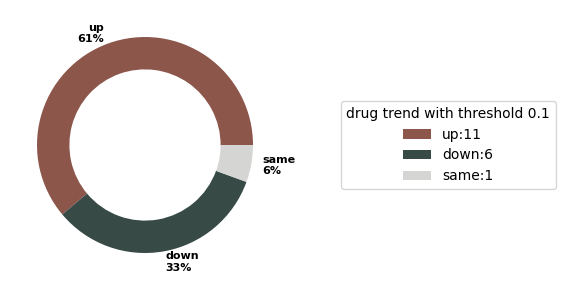

In [11]:
stats = waveforms_adata.obs.drop_duplicates()
unit_counts = {
    'up': 0,
    'down': 0,
    'same': 0,
}
no_change_threshold = 0.1
def count_unit(grouped):
    rate_after = grouped[grouped['condition'] == f'after-{substance}']['firing_rate'].item() if (grouped['condition'] == f'after-{substance}').sum() > 0 else 0
    rate_before = grouped[grouped['condition'] == f'before-{substance}']['firing_rate'].item() if (grouped['condition'] == f'before-{substance}').sum() > 0 else 0
    rate_diffs[substance].append(rate_after - rate_before)
    
    difference = abs(rate_after - rate_before)
    if difference <= no_change_threshold:
        unit_counts['same'] += 1
    elif rate_after > rate_before:
        unit_counts['up'] += 1
    else:
        unit_counts['down'] += 1
stats.groupby(['subject', 'unit_id']).apply(count_unit)


fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

counts = list(unit_counts.values())
trend_counts = [f'{k}:{v}' for k,v in unit_counts.items()]
trend_percents = [f'{k}\n{v/sum(unit_counts.values())*100:0.0f}%' for k,v in unit_counts.items()]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, autotexts = ax.pie(counts, labels=trend_percents,
                                wedgeprops=dict(width=0.3), colors=['#8C564B', '#374A46', '#d5d5d4'])

ax.legend(wedges, trend_counts,
        title=f'{substance} trend with threshold {no_change_threshold}',
        loc="center left",
        bbox_to_anchor=(1.2, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(f'{figure_output_folder}/drug_donut.pdf', bbox_inches='tight')
plt.setp(autotexts, size=8, weight="bold")
plt.show()

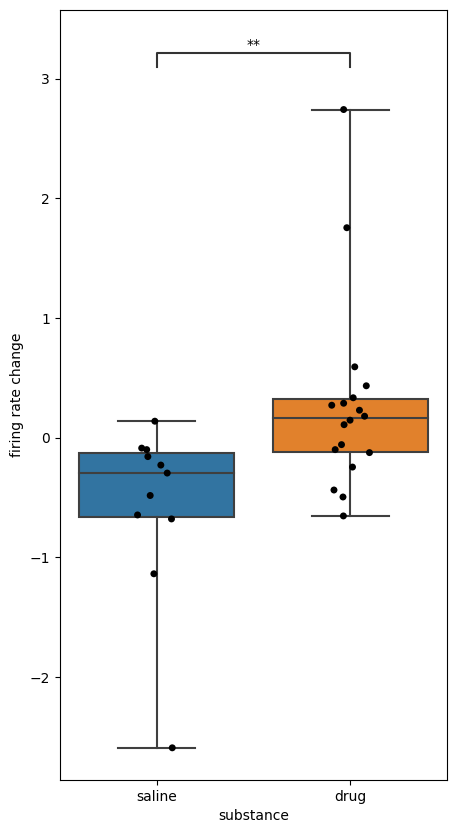

In [12]:

df = []
for substance, diffs in rate_diffs.items():
    df.append(pd.DataFrame({'substance': substance, 'firing rate change': diffs}))
df = pd.concat(df)
plt.figure(figsize=(5, 10))
ax = plt.gca()
# sns.barplot(data=df, x='substance', y='firing rate change', capsize=0.1, ax=ax)
sns.boxplot(data=df, x='substance', y='firing rate change', ax=ax, whis=(0, 100))
sns.stripplot(data=df, x='substance', y='firing rate change', ax=ax, color='black')
annotator = Annotator(ax, [('saline', 'drug')], verbose=False, data=df, x='substance', y='firing rate change')
annotator.configure(test="t-test_welch").apply_and_annotate() # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel
plt.savefig(f'{figure_output_folder}/comparison.pdf')
plt.show()
plt.close()
